In [300]:
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sm_api

%matplotlib inline

db_file = 'elderspeak_detect.db'
con = sqlite3.connect(db_file)

df = pd.read_sql_query('''
    select	
        td.elderspeak,
		pr.spraaksnelheid,
		pr.geluidsniveau,
       	pr.toonhoogte,
        tr.cilt,
        tr.woordlengteratio,
        tr.aantal_collectieve_voornaamwoorden,
        tr.aantal_verkleinwoorden,
        tr.aantal_herhalingen,
        tr.textcat_elderspeak_score,
        id1.geslacht,
        id1.leeftijd,
        id1.moedertaal,
        id1.student_zorg,
        id1.werk_zorg
    from praat_resultaten pr
    join tekst_resultaten tr on pr.audio_id = tr.audio_id
    join teksten t on t.tekst_id = tr.tekst_id
    join test_data td on td.audio_id = tr.audio_id
    left join input_data id1 on tr.audio_id in (id1.leeftijdsgenoot_opname, id1.oudere_opname) 
    where t.methode = 'GOOGLE_ENKEL_NL_BE'
    and pr.spraaksnelheid > 0''', con)
con.close()

print(f"Aantal kolommen: { len(df.columns) }")
print(f"Aantal rijen: { len(df.index) }")
df.tail()

Aantal kolommen: 15
Aantal rijen: 29


,elderspeak,spraaksnelheid,geluidsniveau,toonhoogte,cilt,woordlengteratio,aantal_collectieve_voornaamwoorden,aantal_verkleinwoorden,aantal_herhalingen,textcat_elderspeak_score,geslacht,leeftijd,moedertaal,student_zorg,werk_zorg
24,1,3.429656,71.885632,133.827869,60.01,0.138614,2,4,4,0.012224,M,56,nl,0,0
25,0,3.681592,64.934028,164.553071,62.66,0.066667,1,3,0,0.999969,M,42,nl,0,0
26,0,2.648047,69.161574,176.246320,64.77,0.067227,5,3,4,0.000543,V,37,nl,0,0
27,1,3.418308,65.527924,160.946810,65.66,0.072165,2,4,6,0.999956,M,42,nl,0,0
28,0,3.959729,71.208296,297.522137,65.18,0.056075,5,1,4,0.022516,V,54,nl,0,0


In [301]:
df.corr()

,elderspeak,spraaksnelheid,geluidsniveau,toonhoogte,cilt,woordlengteratio,aantal_collectieve_voornaamwoorden,aantal_verkleinwoorden,aantal_herhalingen,textcat_elderspeak_score,leeftijd,student_zorg,werk_zorg
elderspeak,1.000000,-0.382333,-0.186732,-0.006952,0.326352,-0.166544,0.009493,-0.143500,0.150615,0.162679,0.219624,0.028307,-0.118048
spraaksnelheid,-0.382333,1.000000,0.532835,0.140179,-0.066716,-0.055197,0.032530,-0.075267,0.026559,-0.238025,-0.320460,-0.036180,0.445223
geluidsniveau,-0.186732,0.532835,1.000000,-0.138308,0.203643,-0.122898,0.000194,-0.027880,0.188041,0.123953,-0.302061,0.079529,0.100656
toonhoogte,-0.006952,0.140179,-0.138308,1.000000,-0.037149,-0.025913,0.314063,-0.400083,-0.012832,-0.315231,-0.274457,0.307277,0.131073
cilt,0.326352,-0.066716,0.203643,-0.037149,1.000000,-0.815539,0.031306,-0.213376,0.245501,0.222210,-0.181998,0.100815,0.016091
woordlengteratio,-0.166544,-0.055197,-0.122898,-0.025913,-0.815539,1.000000,-0.309233,-0.016104,-0.445889,-0.199959,0.155708,-0.170349,-0.045367
aantal_collectieve_voornaamwoorden,0.009493,0.032530,0.000194,0.314063,0.031306,-0.309233,1.000000,0.176101,0.476264,-0.183996,0.201830,0.103804,-0.094904
aantal_verkleinwoorden,-0.143500,-0.075267,-0.027880,-0.400083,-0.213376,-0.016104,0.176101,1.000000,0.594852,0.050029,0.250572,-0.113135,-0.124978
aantal_herhalingen,0.150615,0.026559,0.188041,-0.012832,0.245501,-0.445889,0.476264,0.594852,1.000000,-0.066879,-0.083542,0.187942,-0.011414
textcat_elderspeak_score,0.162679,-0.238025,0.123953,-0.315231,0.222210,-0.199959,-0.183996,0.050029,-0.066879,1.000000,0.139100,-0.131429,-0.335858


In [302]:
reg = sm.ols(formula="elderspeak ~ spraaksnelheid + geluidsniveau + toonhoogte + cilt + woordlengteratio + aantal_collectieve_voornaamwoorden + aantal_verkleinwoorden + aantal_herhalingen + textcat_elderspeak_score + leeftijd", data=df).fit()
reg.params

Intercept                            -2.654655
spraaksnelheid                       -0.088247
geluidsniveau                        -0.011990
toonhoogte                           -0.000245
cilt                                  0.052341
woordlengteratio                      4.212949
aantal_collectieve_voornaamwoorden   -0.046817
aantal_verkleinwoorden               -0.143469
aantal_herhalingen                    0.135112
textcat_elderspeak_score              0.157793
leeftijd                              0.013288
dtype: float64

In [303]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             elderspeak   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.410
Date:                Tue, 24 May 2022   Prob (F-statistic):              0.252
Time:                        20:30:45   Log-Likelihood:                -12.503
No. Observations:                  29   AIC:                             47.01
Df Residuals:                      18   BIC:                             62.05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -2.6547      4.247     -0.625      0.540     -11.576       6.267
spraaksnelheid                        -0.0882      0.162     -0.545      0.592      -0.428       0.252
geluidsniveau                         -0.0120      0.015     -0.802      0.433      -0.043       0.019
toonhoogte                            -0.0002      0.002     -0.105      0.917      -0.005       0.005
cilt                                   0.0523      0.058      0.904      0.378      -0.069       0.174
woordlengteratio                       4.2129      5.442      0.774      0.449      -7.220      15.646
aantal_collectieve_voornaamwoorden    -0.0468      0.076     -0.618      0.544      -0.206       0.112
aantal_verkleinwoorden                -0.1435      0.082     -1.749      0.097      -0.316       0.029
aantal_herhalingen                     0.1351      0.064      2.109      0.049       0.000       0.270
textcat_elderspeak_score               0.1578      0.266      0.592      0.561      -0.402       0.718
leeftijd                               0.0133      0.009      1.442      0.166      -0.006       0.033
==============================================================================
Omnibus:                        3.787   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                1.541
Skew:                          -0.076   Prob(JB):                        0.463
Kurtosis:                       1.881   Cond. No.                     1.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

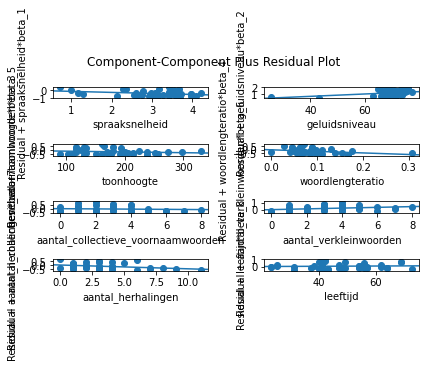

In [312]:
fig = sm_api.graphics.plot_ccpr_grid(reg)
fig.tight_layout(pad=1.0)

In [305]:
con = sqlite3.connect(db_file)
df = pd.read_sql_query('''
    select 	pr.spraaksnelheid,
            pr.geluidsniveau,
            pr.toonhoogte,
            tr.cilt,
            tr.woordlengteratio,
            tr.aantal_collectieve_voornaamwoorden,
            tr.aantal_verkleinwoorden,
            tr.aantal_herhalingen,
            tr.textcat_elderspeak_score,
            id.leeftijd
    from praat_resultaten pr
    join tekst_resultaten tr on tr.audio_id = pr.audio_id
    join teksten t on t.tekst_id = tr.tekst_id
    left join input_data id on tr.audio_id in (id.leeftijdsgenoot_opname, id.oudere_opname) 
    where t.methode = 'GOOGLE_ENKEL_NL_BE'
    and pr.spraaksnelheid > 0;''', con)
con.close()

print(f"Aantal kolommen: { len(df.columns) }")
print(f"Aantal rijen: { len(df.index) }")
df.tail()

Aantal kolommen: 10
Aantal rijen: 39


,spraaksnelheid,geluidsniveau,toonhoogte,cilt,woordlengteratio,aantal_collectieve_voornaamwoorden,aantal_verkleinwoorden,aantal_herhalingen,textcat_elderspeak_score,leeftijd
34,3.730843,74.908909,200.939246,65.17,0.084034,5,3,4,0.142113,54
35,2.952756,73.815941,103.066537,64.14,0.068966,2,2,4,0.032702,43
36,3.581527,69.460416,255.741484,64.22,0.065693,7,7,7,0.000798,54
37,3.959729,71.208296,297.522137,65.18,0.056075,5,1,4,0.022516,54
38,3.415560,69.129282,195.178867,61.31,0.106796,6,5,3,0.000624,54


In [306]:
reg = sm.ols(formula="textcat_elderspeak_score ~ spraaksnelheid + geluidsniveau + toonhoogte + woordlengteratio + aantal_collectieve_voornaamwoorden + aantal_verkleinwoorden + aantal_herhalingen + leeftijd", data=df).fit()
reg.params

Intercept                            -0.190437
spraaksnelheid                       -0.134894
geluidsniveau                         0.016714
toonhoogte                           -0.000953
woordlengteratio                     -2.146306
aantal_collectieve_voornaamwoorden   -0.014231
aantal_verkleinwoorden                0.054133
aantal_herhalingen                   -0.046103
leeftijd                              0.001575
dtype: float64

In [307]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     textcat_elderspeak_score   R-squared:                       0.234
Model:                                  OLS   Adj. R-squared:                  0.030
Method:                       Least Squares   F-statistic:                     1.144
Date:                      Tue, 24 May 2022   Prob (F-statistic):              0.364
Time:                              20:30:47   Log-Likelihood:                -12.855
No. Observations:                        39   AIC:                             43.71
Df Residuals:                            30   BIC:                             58.68
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.1904      0.774     -0.246      0.807      -1.772       1.391
spraaksnelheid                        -0.1349      0.106     -1.276      0.212      -0.351       0.081
geluidsniveau                          0.0167      0.009      1.760      0.089      -0.003       0.036
toonhoogte                            -0.0010      0.001     -0.679      0.502      -0.004       0.002
woordlengteratio                      -2.1463      1.393     -1.540      0.134      -4.992       0.700
aantal_collectieve_voornaamwoorden    -0.0142      0.045     -0.315      0.755      -0.106       0.078
aantal_verkleinwoorden                 0.0541      0.048      1.116      0.273      -0.045       0.153
aantal_herhalingen                    -0.0461      0.043     -1.075      0.291      -0.134       0.042
leeftijd                               0.0016      0.006      0.256      0.800      -0.011       0.014
==============================================================================
Omnibus:                        5.785   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.391
Skew:                           0.909   Prob(JB):                       0.0675
Kurtosis:                       2.884   Cond. No.                     4.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [319]:
con = sqlite3.connect(db_file)
df = pd.read_sql_query('''
    select	pr.spraaksnelheid,
            pr.geluidsniveau,
            pr.toonhoogte,
            tr.cilt,
            tr.woordlengteratio,
            tr.aantal_collectieve_voornaamwoorden,
            tr.aantal_verkleinwoorden,
            tr.aantal_herhalingen,
            tr.textcat_elderspeak_score,
            id.geslacht,
            id.leeftijd,
            id.moedertaal,
            id.student_zorg,
            id.werk_zorg
    from input_data id
    join tekst_resultaten tr on id.oudere_opname = tr.audio_id
    join teksten t on t.tekst_id = tr.tekst_id
    join praat_resultaten pr on pr.audio_id = id.oudere_opname
    where t.methode = 'GOOGLE_ENKEL_NL_BE';''', con)
con.close()

print(f"Aantal kolommen: { len(df.columns) }")
print(f"Aantal rijen: { len(df.index) }")
df.tail()

Aantal kolommen: 14
Aantal rijen: 19


,spraaksnelheid,geluidsniveau,toonhoogte,cilt,woordlengteratio,aantal_collectieve_voornaamwoorden,aantal_verkleinwoorden,aantal_herhalingen,textcat_elderspeak_score,geslacht,leeftijd,moedertaal,student_zorg,werk_zorg
14,3.429656,71.885632,133.827869,60.01,0.138614,2,4,4,0.012224,M,56,nl,0,0
15,3.418308,65.527924,160.946810,65.66,0.072165,2,4,6,0.999956,M,42,nl,0,0
16,3.730843,74.908909,200.939246,65.17,0.084034,5,3,4,0.142113,V,54,nl,0,0
17,2.952756,73.815941,103.066537,64.14,0.068966,2,2,4,0.032702,M,43,nl,0,0
18,3.959729,71.208296,297.522137,65.18,0.056075,5,1,4,0.022516,V,54,nl,0,0


In [320]:
df.corr()

,spraaksnelheid,geluidsniveau,toonhoogte,cilt,woordlengteratio,aantal_collectieve_voornaamwoorden,aantal_verkleinwoorden,aantal_herhalingen,textcat_elderspeak_score,leeftijd,student_zorg,werk_zorg
spraaksnelheid,1.000000,0.454382,0.111075,-0.202980,0.043696,0.141025,0.083172,0.024828,-0.294011,-0.363145,-0.122483,0.464844
geluidsniveau,0.454382,1.000000,-0.110778,0.010751,-0.081384,0.242921,-0.205634,-0.125443,0.095811,-0.259103,0.053059,0.171403
toonhoogte,0.111075,-0.110778,1.000000,-0.320205,0.296773,0.139859,-0.266954,-0.038976,-0.281456,-0.161842,0.259784,0.165429
cilt,-0.202980,0.010751,-0.320205,1.000000,-0.872934,-0.149258,-0.133903,0.080448,0.371943,-0.092981,0.008876,-0.142549
woordlengteratio,0.043696,-0.081384,0.296773,-0.872934,1.000000,-0.165253,-0.165396,-0.466500,-0.305138,0.153136,-0.180319,0.143506
aantal_collectieve_voornaamwoorden,0.141025,0.242921,0.139859,-0.149258,-0.165253,1.000000,0.448260,0.625745,0.043094,0.190100,0.033360,-0.326860
aantal_verkleinwoorden,0.083172,-0.205634,-0.266954,-0.133903,-0.165396,0.448260,1.000000,0.739702,0.065171,0.006603,0.103203,-0.077243
aantal_herhalingen,0.024828,-0.125443,-0.038976,0.080448,-0.466500,0.625745,0.739702,1.000000,0.135381,-0.028254,0.310080,-0.317512
textcat_elderspeak_score,-0.294011,0.095811,-0.281456,0.371943,-0.305138,0.043094,0.065171,0.135381,1.000000,-0.026084,-0.073773,-0.285344
leeftijd,-0.363145,-0.259103,-0.161842,-0.092981,0.153136,0.190100,0.006603,-0.028254,-0.026084,1.000000,-0.446959,-0.443494
